# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `24`
* Students: `Marc Glettig, Matthias Minder, Yves Rychener, Charles Trotin`
* Dataset: `Wikipedia Dataset`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [4]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [5]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [6]:
DATA_FOLDER = 'data/'

In [7]:
adjacency = np.load(DATA_FOLDER + 'sym_adj_matrix_lc.npy')
n_nodes =  adjacency.shape[0]

*We use only the largest component, because as seen in assignement 1, our network consists of 1 component and some disconnected nodes. The disconnected nodes have degree zero, so the diagonal matrix D has some diagonal entries that are 0. Therefore D is not invertible, so we cannot construct the normalised Laplacian with the whole network.*

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [8]:
D = np.diag(np.sum(adjacency,axis=0))
D_sqrt_inv = sparse.csr_matrix(np.diag(1/np.sqrt(np.sum(adjacency,axis=0))))

In [9]:
laplacian_combinatorial =  sparse.csr_matrix(D - adjacency, dtype=float)
laplacian_normalized =  D_sqrt_inv*laplacian_combinatorial*D_sqrt_inv

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [10]:
laplacian =  laplacian_normalized

### Question 2

Compute the eigendecomposition of the Laplacian $L = U \Lambda U^\top$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [11]:
vals,vec = w, v = np.linalg.eig(laplacian.toarray())

In [12]:
order = vals.argsort()

eigenvectors =  np.real(vec[order,:])
eigenvalues =  np.real(vals[order])

assert eigenvectors.shape == (n_nodes, n_nodes)

*Verifying that $\lambda_1=0$:*

In [13]:
eigenvalues[0]

-2.6584170793976933e-16

*Verifying that the eigenvalues are all real:*

In [14]:
print('Sum of eigenvalue complex parts:'+str(np.sum(np.imag(vals))))
print('Sum of eigenvector complex parts:'+str(np.sum(np.imag(vec))))

Sum of eigenvalue complex parts:0.0
Sum of eigenvector complex parts:2.513529388145309e-17


Justify your choice of eigensolver.

*Ideally, we would want to use a sparse eigensolver, but the solver in `scipy.sparse.linalg.eigs` can not compute all eigenvalues and -vectors, which is what we need in order to perform eigendecomposition. We therefore use the solver in `numpy.linalg`, it suffices for our purposes. The eigenvalues are ordered in increasing order, so we have to flip the arrays of eigenvalues and eigenvectors. <br>
The fact that the smallest eigenvalue is not exactly zero can probably be attributed to rounding errors of the float datatype.*

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

*$S$ can be thaught of as a finite difference operator along edges. $(S^\top x)[j]$ is the derivative of the signal along the edge $j$. Therefore, $S^\top x$ calculates the derivative along all edges. Note that although we use the term derivative, it is not a derivative in the strict sense as we cannot let the distance tend to 0. It is just the difference of the signal value at the two nodes neighbouring an edge.*


### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

*We know that $L = U \Lambda U^\top = S S^\top$, where $\Lambda^\top =\Lambda$ is a diagonal matrix. Therefore $S=U \Lambda^{1/2}$. So $S^\top=\Lambda^{1/2} U^\top$. Then 
$U^\top u_k$ is a vector of zeros except $1$ at the k-th entry (since the $u_i$ are orthonormal). Multiplying by $\Lambda^{1/2}$, we get a vector of zeros except $\lambda_k^{1/2}$ at the k-th entry. Then the L2 norm of this vector ($S^\top u_k$) is $\sqrt{\lambda_k}$. Taking the square gives $\lambda_k$.*


What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

*$\| S^\top x \|_2^2$ is a measure of how much the signal $x$ varies across the graph.*

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

*Since $u_0$ is the first eigenvector, it is more than 5000 dimensional. Writing down such a vector is useless. We chose to plot the entries of the vector.*

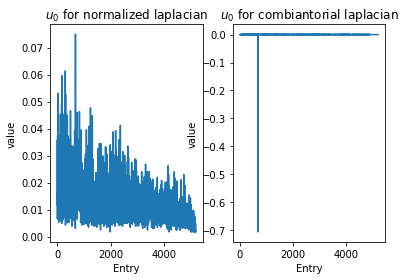

In [16]:
u0_normalized = np.load(DATA_FOLDER + 'u0_normalized.npy')
u0_unnormalized = np.load(DATA_FOLDER + 'u0_unnormalized.npy')

plt.figure()
plt.subplot(121)
plt.plot(np.real(u0_normalized))
plt.title('$u_0$ for normalized laplacian')
plt.xlabel('Entry')
plt.ylabel('value')
plt.subplot(122)
plt.plot(np.real(u0_unnormalized))
plt.title('$u_0$ for combiantorial laplacian')
plt.xlabel('Entry')
plt.ylabel('value')
plt.show()

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

Text(0, 0.5, 'Eigenvalue')

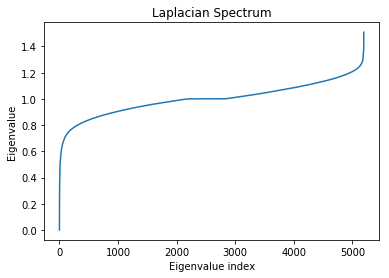

In [17]:
plt.plot(eigenvalues)
plt.title('Laplacian Spectrum')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')

*We see that the eigenvalue is well inside the theoretical bounds. Also, unsurprisingly, we do not have a biparteite graph.*

How many connected components are there in your graph? Answer using the eigenvalues only.

In [19]:
eigenvalues[:10]

array([-2.65841708e-16,  2.50814625e-01,  2.99631395e-01,  3.39686285e-01,
        3.46145938e-01,  3.71966112e-01,  4.02659397e-01,  4.20128875e-01,
        4.36375249e-01,  4.52050168e-01])

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

*We see that only the first eigenvalue is very small (in the order of float rounding errors). Therefore, there is only one component.<br>
There is no theoretical upper bound for eigenvalues for the combinatorial laplacian. For the normalized laplacian the theoretrical upper bound is 2. This bound is only obtained in a biparteite graph. We get the biggest eigenvalue to be ~1.5 for the normalized laplacian and ~1895 for the combinatorial laplacian.*

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

*Laplacian eigenmaps and graph embeddings in general can be used to represent every vertex of a graph in an Euclidian space such that connected vertices have a small euclidian distance. This allows for a visualization of the graph. Moreover, computing Laplacian eigenmaps of nearest-neighbor graphs provides a tool for dimensionality reduction of complex data that allows to capture non-linear interactions.*

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [102]:
D_sparse = sparse.csr_matrix(D,dtype=float)
evals_c, evecs_c = sparse.linalg.eigs(laplacian_combinatorial,M=D_sparse,k=3, which='SM')
evals_n, evecs_n = sparse.linalg.eigs(laplacian,k=3, which='SM')

evals_n.shape


(3,)

Plot the nodes embedded in 2D. Comment on what you see.

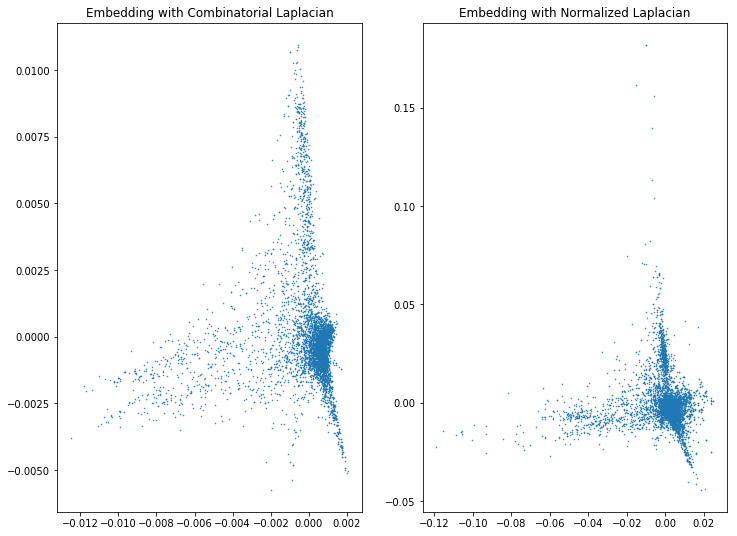

In [103]:
plt.figure(figsize=[12,9])
plt.subplot(121)
plt.plot(np.real(evecs_c[:,1]),np.real(evecs_c[:,2]),'.',markersize=1)
plt.title('Embedding with Combinatorial Laplacian')
plt.subplot(122)
plt.plot(np.real(evecs_n[:,1]),np.real(evecs_n[:,2]),'.',markersize=1)
plt.title('Embedding with Normalized Laplacian')
plt.show()

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

Embedding the Graph in a d-dimensional subspace preserves the neighbourhood of the nodes.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

Plot Eigenvalues over k then decide

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [81]:
#Since we have more than two categories we will run k-means on Z;
Z_test=[[1,1],[1,3],[2,2],[3,9],[4,9],[5,9],[6,2],[7,1],[7,3]]

def cl_assign(Z,k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Z)
    return(kmeans.labels_,kmeans.cluster_centers_)

In [82]:
cl_assign(Z_test,3)

(array([2, 2, 2, 0, 0, 0, 1, 1, 1], dtype=int32),
 array([[4.        , 9.        ],
        [6.66666667, 2.        ],
        [1.33333333, 2.        ]]))

**ELBOW Approach:**
We plot of the within cluster variation $W_K(C)$ for increasing values of K =1 ,2,...and try to locate a “kink” in the curve. 

In [83]:
def wk(k,Z):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Z)
    clusters=kmeans.labels_
    centers=kmeans.cluster_centers_
    Liste=list(zip(Z,clusters))
    wc=0
    for p in range(k):
        for points in [Liste[i][0] for i in range(len(Z)) 
            if Liste[i][1]==p]:
                wc=wc+np.linalg.norm(np.array(points)-np.array(centers[p]))**2
    return wc 

def elbow(Z,n):
    visu=[]
    j = len(Z)+1; 
    if j >= n: j=n;
    for k in range(1,j):
        visu.append(wk(k,Z))
    plt.plot(np.linspace(1,len(visu),len(visu)),visu)
    plt.show()

/Users/marcglettig/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


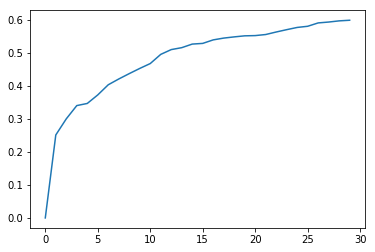

In [101]:
plt.plot(evals_n)

In [29]:
A=np.array([1,2])-np.array([2,3])
print(A)

[-1 -1]


### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [30]:
def reorder(adj,cl_assign):
    new_order=[[cl_assign[i],int(np.linspace(0,len(cl_assign),len(cl_assign)+1)[i])] for i in range(len(cl_assign))]
    print(new_order)
    new_order.sort()
    print(new_order)
    new_order=[i[1] for i in new_order]
    print(new_order)
    reordered_adj= [[adj[k][l] for k in new_order] for l in new_order]
    return reordered_adj

adja=[[  0.,  15.,   0.,   7.,  10.,   0.],
        [ 15.,   0.,   9.,  11.,   0.,   9.],
        [  0.,   9.,   0.,   0.,  12.,   7.],
        [  7.,  11.,   0.,   0.,   8.,  14.],
        [ 10.,   0.,  12.,   8.,   0.,   8.],
        [  0.,   9.,   7.,  14.,   8.,   0.]]
cl_assign_test=[2,1,1,0,2,0]
reorder(adja,cl_assign_test)

#l=[[0, 3], [0, 9], [0, 0],[-21, 9], [41.5, 0]]
#new_order=[[l[i],int(np.linspace(0,len(l),len(l)+1)[i])] for i in range(len(l))]
#new_order.sort()
#print(new_order)

[[2, 0], [1, 1], [1, 2], [0, 3], [2, 4], [0, 5]]
[[0, 3], [0, 5], [1, 1], [1, 2], [2, 0], [2, 4]]
[3, 5, 1, 2, 0, 4]


[[0.0, 14.0, 11.0, 0.0, 7.0, 8.0],
 [14.0, 0.0, 9.0, 7.0, 0.0, 8.0],
 [11.0, 9.0, 0.0, 9.0, 15.0, 0.0],
 [0.0, 7.0, 9.0, 0.0, 0.0, 12.0],
 [7.0, 0.0, 15.0, 0.0, 0.0, 10.0],
 [8.0, 8.0, 0.0, 12.0, 10.0, 0.0]]

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [31]:
A=[3,2,1]
B=[1,2,3]

#Clusters=cl_assign(Z,k):
Z_test=[[1,1],[1,3],[2,2],[3,9],[4,9],[5,9],[6,2],[7,1],[7,3]]

Clusters=cl_assign(Z_test,3)

Liste=list(zip(Z_test,Clusters))

for p in range(max(Clusters)+1):
    print(p)
    data=[Liste[i][0] for i in range(len(Z_test)) if Liste[i][1]==p]
    plt.plot([item[1] for item in data],[item[0] for item in data],color=[1-p/max(Clusters),p/max(Clusters),0.5],marker='o',linewidth=0)
plt.show()


ValueError: operands could not be broadcast together with shapes (3,2) (9,) 

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [20]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**